# Modèle Naive Bayes

par Ali

## 1. Télechargement des packages nécessaires

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score

## 2. Importation des ensembles d'entraînement et de test.

In [2]:
with open('variables.pkl', 'rb') as f:
    (df, X_train, X_test, y_train, y_test,X_train_smote, y_train_smote) = pickle.load(f)

In [3]:
print(df.columns)

Index(['comportement_risqueSexuel', 'comportement_alimentation',
       'comportement_hygienePersonnelle', 'intention_aggrégation',
       'intention_engagement', 'attitude_cohérence', 'attitude_spontanéité',
       'norme_personneImportante', 'norme_accomplissement',
       'perception_vulnérabilité', 'perception_sévérité', 'motivation_force',
       'motivation_volonté', 'soutienSocial_émotionnel',
       'soutienSocial_appréciation', 'soutienSocial_instrumental',
       'autonomisation_connaissance', 'autonomisation_compétences',
       'autonomisation_désirs', 'cancer_colUterus'],
      dtype='object')


In [4]:
print(df.shape)

(72, 20)


## 3. Naive Bayes

### 3.1 Entraînement des modèles avec SMOTE


 GaussianNB - Accuracy: 0.90
 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.78      0.88      0.82         8

    accuracy                           0.90        29
   macro avg       0.86      0.89      0.88        29
weighted avg       0.90      0.90      0.90        29

 Matrice de Confusion :
 [[19  2]
 [ 1  7]]

 BernoulliNB - Accuracy: 0.90
 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.78      0.88      0.82         8

    accuracy                           0.90        29
   macro avg       0.86      0.89      0.88        29
weighted avg       0.90      0.90      0.90        29

 Matrice de Confusion :
 [[19  2]
 [ 1  7]]

 MultinomialNB - Accuracy: 0.86
 Rapport de Classification :
               precision    recall  f1-score   support

           0       

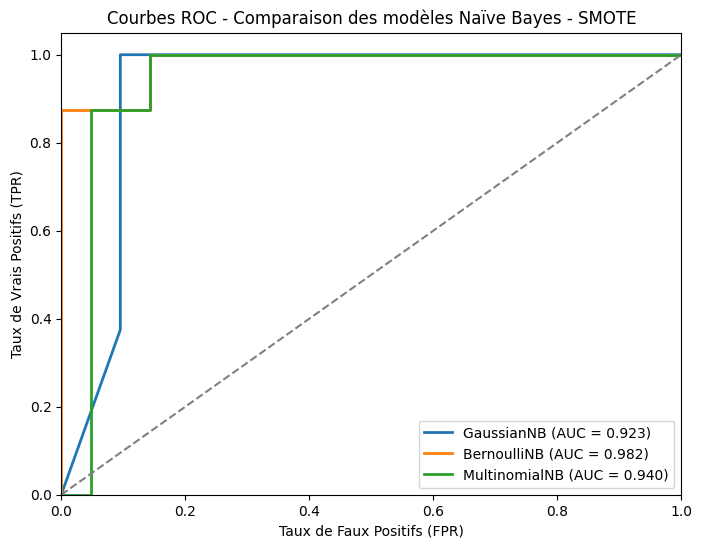


Tableau de comparaison des modèles avec SMOTE :
+---------------+------------+------------+---------+
| Modèle        |   Accuracy |   F1-Score |     AUC |
+===============+============+============+=========+
| GaussianNB    |    0.89655 |    0.82353 | 0.92262 |
+---------------+------------+------------+---------+
| BernoulliNB   |    0.89655 |    0.82353 | 0.98214 |
+---------------+------------+------------+---------+
| MultinomialNB |    0.86207 |    0.8     | 0.94048 |
+---------------+------------+------------+---------+


In [5]:
# Initialisation des modèles Naïve Bayes
models = {
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "MultinomialNB": MultinomialNB()
}

# Normalisation : adapte les données pour chaque modèle
scaler_standard = StandardScaler()  # Pour GaussianNB et BernoulliNB (moyenne=0, écart-type=1)
scaler_minmax = MinMaxScaler()      # Pour MultinomialNB (valeurs entre 0 et 1, pas de négatifs)

# Normalisation :
# - StandardScaler : centre les données (moy=0, écart=1), ok pour GaussianNB et BernoulliNB.
# - MinMaxScaler : met tout entre [0,1], requis pour MultinomialNB (pas de valeurs négatives).
# - fit_transform sur train : calcule params et applique.
# - transform sur test : utilise params de train, évite data leakage.
X_train_scaled_standard = scaler_standard.fit_transform(X_train_smote)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train_smote)
X_test_scaled_standard = scaler_standard.transform(X_test)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Entraînement et évaluation des modèles
results_smote = {}
metrics = {} 
table_data = []

for name, model in models.items():
    if name == "MultinomialNB":
        model.fit(X_train_scaled_minmax, y_train_smote)
        y_pred = model.predict(X_test_scaled_minmax)
        y_prob = model.predict_proba(X_test_scaled_minmax)[:, 1]
    else:
        model.fit(X_train_scaled_standard, y_train_smote)
        y_pred = model.predict(X_test_scaled_standard)
        y_prob = model.predict_proba(X_test_scaled_standard)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0) 
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calcul de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Stockage dans results
    results_smote[name] = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": conf_matrix,
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
        "y_pred": y_pred
    }

    metrics[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
        "y_pred": y_pred
    }
    table_data.append([name, f"{accuracy:.5f}", f"{f1:.5f}", f"{roc_auc:.5f}"])

    print(f"\n {name} - Accuracy: {accuracy:.2f}")
    print(" Rapport de Classification :\n", report)
    print(" Matrice de Confusion :\n", conf_matrix)

# Affichage des courbes ROC
plt.figure(figsize=(8,6))
for name, res in results_smote.items():
    plt.plot(res["fpr"], res["tpr"], lw=2, label=f'{name} (AUC = {res["auc"]:.3f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC - Comparaison des modèles Naïve Bayes - SMOTE')
plt.legend(loc="lower right")
plt.show()

# Création du tableau comparatif 
headers = ["Modèle", "Accuracy", "F1-Score", "AUC"]
print("\nTableau de comparaison des modèles avec SMOTE :")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

### 3.2 Entraînement des modèles sans SMOTE


 GaussianNB - Accuracy: 0.90
 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.78      0.88      0.82         8

    accuracy                           0.90        29
   macro avg       0.86      0.89      0.88        29
weighted avg       0.90      0.90      0.90        29

 Matrice de Confusion :
 [[19  2]
 [ 1  7]]

 BernoulliNB - Accuracy: 0.90
 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.73      1.00      0.84         8

    accuracy                           0.90        29
   macro avg       0.86      0.93      0.88        29
weighted avg       0.92      0.90      0.90        29

 Matrice de Confusion :
 [[18  3]
 [ 0  8]]

 MultinomialNB - Accuracy: 0.76
 Rapport de Classification :
               precision    recall  f1-score   support

           0       

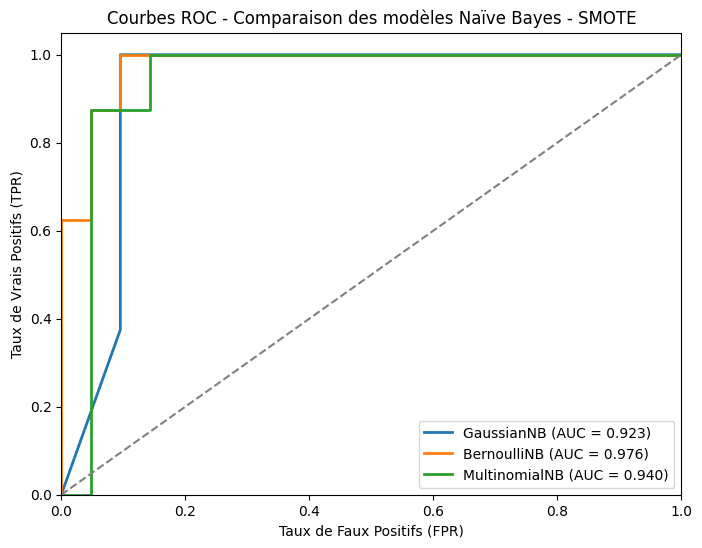


Tableau de comparaison des modèles sans SMOTE :
+---------------+------------+------------+---------+
| Modèle        |   Accuracy |   F1-Score |     AUC |
+===============+============+============+=========+
| GaussianNB    |    0.89655 |    0.89833 | 0.92262 |
+---------------+------------+------------+---------+
| BernoulliNB   |    0.89655 |    0.90074 | 0.97619 |
+---------------+------------+------------+---------+
| MultinomialNB |    0.75862 |    0.7166  | 0.94048 |
+---------------+------------+------------+---------+


In [6]:
# Initialisation des modèles Naïve Bayes
models = {
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "MultinomialNB": MultinomialNB()
}

# Normalisation : adapte les données pour chaque modèle
scaler_standard = StandardScaler()  # Pour GaussianNB et BernoulliNB (moyenne=0, écart-type=1)
scaler_minmax = MinMaxScaler()      # Pour MultinomialNB (valeurs entre 0 et 1, pas de négatifs)

# Normalisation :
# - StandardScaler : centre les données (moy=0, écart=1), ok pour GaussianNB et BernoulliNB.
# - MinMaxScaler : met tout entre [0,1], requis pour MultinomialNB (pas de valeurs négatives).
# - fit_transform sur train : calcule params et applique.
# - transform sur test : utilise params de train, évite data leakage.
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Entraînement et évaluation des modèles
results = {}
metrics = {} 
table_data = []

for name, model in models.items():
    if name == "MultinomialNB":
        model.fit(X_train_scaled_minmax, y_train)
        y_pred = model.predict(X_test_scaled_minmax)
        y_prob = model.predict_proba(X_test_scaled_minmax)[:, 1]
    else:
        model.fit(X_train_scaled_standard, y_train)
        y_pred = model.predict(X_test_scaled_standard)
        y_prob = model.predict_proba(X_test_scaled_standard)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred, zero_division=0) 
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calcul de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Stockage dans results
    results[name] = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": conf_matrix,
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
        "y_pred": y_pred
    }

    metrics[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
        "y_pred": y_pred
    }
    table_data.append([name, f"{accuracy:.5f}", f"{f1:.5f}", f"{roc_auc:.5f}"])

    print(f"\n {name} - Accuracy: {accuracy:.2f}")
    print(" Rapport de Classification :\n", report)
    print(" Matrice de Confusion :\n", conf_matrix)

# Affichage des courbes ROC
plt.figure(figsize=(8,6))
for name, res in results.items():
    plt.plot(res["fpr"], res["tpr"], lw=2, label=f'{name} (AUC = {res["auc"]:.3f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC - Comparaison des modèles Naïve Bayes - SMOTE')
plt.legend(loc="lower right")
plt.show()

# Création du tableau comparatif
headers = ["Modèle", "Accuracy", "F1-Score", "AUC"]
print("\nTableau de comparaison des modèles sans SMOTE :")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

## 4. Exporter les variables

In [8]:
roc_data_NB = {
    'fpr_nb': results["BernoulliNB"]["fpr"],
    'tpr_nb': results["BernoulliNB"]["tpr"],
    'auc_nb': results["BernoulliNB"]["auc"],
    'pred_nb': results["BernoulliNB"]["y_pred"]
}

# Sauvegarder les données dans un fichier pickle
with open('Variables/roc_data_NB.pkl', 'wb') as file:
    pickle.dump(roc_data_NB, file)

print("Les données ROC, AUC et prédictions de BernoulliNB ont été enregistrées dans 'roc_data_NB.pkl'.")

Les données ROC, AUC et prédictions de BernoulliNB ont été enregistrées dans 'roc_data_NB.pkl'.
